In [1]:
# General imports
import os
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(5)

# Segmentation
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from astropy.wcs import WCS as wcs

# Spectrum templates
import pysynphot as S
from astropy.table import Table
from glob import glob

# grizli
from grizli.model import GrismFLT
import grizli

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")
root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = "ready_direct_{0}".format(root)
seg_file = "seg_{0}".format(root)

/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/keith/miniconda3/envs/grizli-env/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
# Process direct image and produce segmentation map

# Open image
direct_fits = fits.open(direct_file)
PrimaryHDU = direct_fits[0]
data, header = (direct_fits[1].data, direct_fits[1].header)
# direct_fits.close() # comment out if you plan to save

# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)
threshold = 2 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# # Save seg_map as fits
# fits.writeto(seg_file, seg_map, header=header,overwrite=True)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

In [3]:
# Create Catalog
cat = SourceCatalog(data, seg_map, convolved_data=convolved_data)

# Grizli Expects these later
cat.add_extra_property('id', np.cast[int](cat.label), overwrite=True)
cat.add_extra_property('x_flt', cat.xcentroid, overwrite=True)
cat.add_extra_property('y_flt', cat.ycentroid, overwrite=True)

# Calculate flux using a reference object (reference object info hardcoded)
mag = -2.5 * np.log10(cat.segment_flux/206.04939338564867) + 25.88
cat.add_extra_property('mag', mag, overwrite=True)

# Select random SED and set wavelength and flux
SED_dir = "/Users/keith/astr/research_astr/FOV0/SEDs"
list = os.listdir(SED_dir)
SED = rng.choice(list, size=len(cat))

# Instantiate empty lists for wavelength, flux, and redshift
waves = []
fluxes = []
zs = []

# Give every object a random unique spectrum
for ii, sed in enumerate(SED):
    # Read in template spectrum
    sed_path = os.path.join(SED_dir, sed)
    spectrum = Table.read(sed_path, format="fits")

    # Redshift Spectrum
    rest_wave = spectrum['wavelength']
    z = (10000 / rest_wave.min()) - 1
    redshifted_wave = rest_wave * (z+1)

    # Store spectrum and redshift in lists
    waves.append(redshifted_wave)
    fluxes.append(spectrum['flux'])
    zs.append(z)

# Store object properties in catalog
cat.add_extra_property("wave", waves)
cat.add_extra_property("flux", fluxes)
cat.add_extra_property('z', zs)

# Convert cumbersome catalog into usable table
columns = ['id', 'x_flt', 'y_flt', 'mag', 'wave', 'flux', 'z']
tbl = cat.to_table(columns)

# # Uncomment to save catalog
# seg_cat = "seg_cat.detect.cat"

# if os.path.exists(seg_cat):
#             os.remove(seg_cat)
# tbl.write(seg_cat, format='ascii.commented_header')

In [4]:
# Instantiate the GrismFLT object
pad = 100
roman_sim = GrismFLT(direct_file=direct_file, seg_file=seg_file, pad=pad)



Image cutout: x=slice(0, 4088, None), y=slice(0, 4088, None) [Out of range]
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / Pad ref HDU with 264 pixels
ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits / blot segmentation seg_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [5]:
# Disperse one object at a time, store disperion on original image
for ii, object in enumerate(tbl):
    
    # Pull variables from tbl
    id = object["id"]
    mag = object["mag"]
    wave = object["wave"]
    flux = object["flux"]

    # Compute pysynphot Spectrum
    spec = S.ArraySpectrum(wave=wave, flux=flux)

    roman_sim.compute_model_orders(id, mag=mag, compute_size=False, size=77, 
                                   in_place=True, store=False, spectrum_1d=[spec.wave, spec.flux])

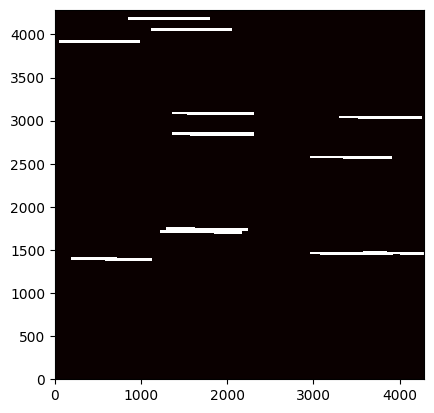

In [6]:
# Show nan locations
nan_locs = np.where(np.isnan(roman_sim.model), roman_sim.model, 0)
plt.imshow(nan_locs, cmap='hot', origin='lower')

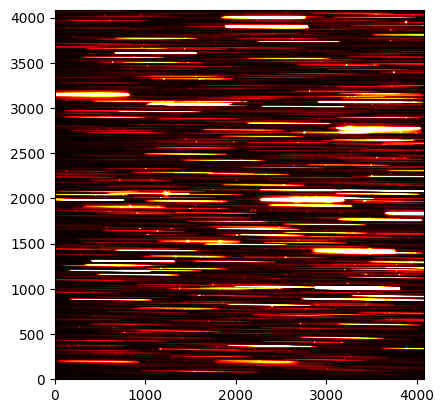

In [7]:
# Show model, masking nans
no_nan_model = np.where(np.isnan(roman_sim.model) == False, roman_sim.model, 0)[pad:-pad, pad:-pad]
plt.imshow(no_nan_model, cmap='hot', origin='lower', vmin=0.001, vmax=no_nan_model.max()/1000)

In [8]:
raise Exception("Pause before saving")

In [9]:
# Primary HDU is opened and closed above. Comment out direct_fits.close() if you plan to save here.

ImageHDU = fits.ImageHDU(data=no_nan_model, header=header, name='SCI')
err_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='ERR')
DQ_HDU = fits.ImageHDU(data=np.zeros_like(roman_sim.model[pad:-pad, pad:-pad]), header=header, name='DQ')

hdul = [PrimaryHDU, ImageHDU, err_HDU, DQ_HDU]

fits.HDUList(hdul).writeto("unique_spectra_{0}".format(root), overwrite=True)